In [1]:
# -*- coding: utf-8 -*-
"""
Training a Classifier
=====================
This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.
Now you might be thinking,
What about data?
----------------
Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.
-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful
Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.
This provides a huge convenience and avoids writing boilerplate code.
For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.
.. figure:: /_static/img/cifar10.png
   :alt: cifar10
   cifar10
Training an image classifier
----------------------------
We will do the following steps in order:
1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data
1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Using ``torchvision``, it’s extremely easy to load CIFAR10.
"""
import torch
import torchvision
import torchvision.transforms as transforms

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].
# .. note::

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
########################################################################
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

truck   cat plane   cat


In [3]:
########################################################################
# 2. Define a Convolutional Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# What to do 
I would like to have multiple neural netorks which are particles. 

Can i get the grads with respect to last layer and input


In [7]:
def sample_index_softmax(weights, positions, beta=1):
    probabilities = softmax(weights, beta)
    pos_filter = np.random.choice(list(range(len(positions))), len(positions), p=probabilities)
    return pos_filter

def softmax(weights, beta=-1):
    # normalize weights:
    weights /= np.sum(weights)
    
    sum_exp_weights = sum([np.exp(beta*w) for w in weights])
    probabilities = np.array([np.exp(beta*w) for w in weights]) / sum_exp_weights
    return probabilities

def weight_function(grad, curr_weights):
    input_shape = grad.shape # batch, filters, x_dim, y_dim
    grad = grad.reshape((input_shape[0], np.product(input_shape[1:]))).T

    return curr_weights + np.sum(np.linalg.norm(grad, axis=0))

In [8]:
import torch.optim as optim

# Get n neural nets and init them
num_nets = 15
tau = 2500 # num batches before resampling
beta = -10

nets = [Net() for _ in range(num_nets)]

nets_weights = np.zeros(num_nets)

#  Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(nets[i].parameters(), lr=0.001, momentum=0) for i in range(num_nets)]

num_epochs = 25

In [12]:
print("samples per nn {}".format(len(trainset)/float(num_nets) * num_epochs))

samples per nn 83333.33333333334


In [9]:
import copy

########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.

for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    running_losses = np.zeros(num_nets)
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # cycle neural net
        curr_nn_idx = i % len(nets)
        net = nets[curr_nn_idx]
        optimizer = optimizers[curr_nn_idx]
        
        # Compute gradients for input. 
        inputs.requires_grad = True

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # update weights
        nets_weights = weight_function(inputs.grad, nets_weights)

        # update statistics
        running_losses[curr_nn_idx] += loss.item()

            
#         # resample particles (if not, do something else potentially)
#         if i % tau == (tau - 1):
#             sampled_idx = sample_index_softmax(nets_weights, nets, beta=0.01)
#             # init nets etc
#             nets = [copy.deepcopy(nets[i]) for i in sampled_idx]
#             optimizers = [optim.SGD(nets[i].parameters(), lr=0.01, momentum=0) for i in range(num_nets)]
#             nets_weights = np.zeros(num_nets)

#             # print statistics 
#             for n_i in range(num_nets):
#                 print('Resampling. [%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_losses[n_i]/float(i % 1000)))
                
        if i % (1000) == (999):
            for n_i in range(num_nets):
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_losses[n_i]/float(1000)))
                running_losses[n_i] = 0.0
                
    # resample particles (if not, do something else potentially)
    sampled_idx = sample_index_softmax(nets_weights, nets, beta=beta)
    # init nets etc
    nets = [copy.deepcopy(nets[i]) for i in sampled_idx]
    optimizers = [optim.SGD(nets[i].parameters(), lr=0.01, momentum=0) for i in range(num_nets)]
    nets_weights = np.zeros(num_nets)



        

print('Finished Training')

########################################################################
# Let's quickly save our trained model:

# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

[1,  1000] loss: 0.154
[1,  1000] loss: 0.154
[1,  1000] loss: 0.155
[1,  1000] loss: 0.155
[1,  1000] loss: 0.155
[1,  1000] loss: 0.154
[1,  1000] loss: 0.154
[1,  1000] loss: 0.154
[1,  1000] loss: 0.155
[1,  1000] loss: 0.155
[1,  1000] loss: 0.152
[1,  1000] loss: 0.152
[1,  1000] loss: 0.152
[1,  1000] loss: 0.152
[1,  1000] loss: 0.152
[1,  2000] loss: 0.154
[1,  2000] loss: 0.154
[1,  2000] loss: 0.154
[1,  2000] loss: 0.154
[1,  2000] loss: 0.155
[1,  2000] loss: 0.152
[1,  2000] loss: 0.152
[1,  2000] loss: 0.152
[1,  2000] loss: 0.152
[1,  2000] loss: 0.152
[1,  2000] loss: 0.155
[1,  2000] loss: 0.155
[1,  2000] loss: 0.155
[1,  2000] loss: 0.154
[1,  2000] loss: 0.154
[1,  3000] loss: 0.152
[1,  3000] loss: 0.152
[1,  3000] loss: 0.152
[1,  3000] loss: 0.152
[1,  3000] loss: 0.152
[1,  3000] loss: 0.154
[1,  3000] loss: 0.154
[1,  3000] loss: 0.154
[1,  3000] loss: 0.155
[1,  3000] loss: 0.155
[1,  3000] loss: 0.154
[1,  3000] loss: 0.154
[1,  3000] loss: 0.154
[1,  3000] 

[3,  1000] loss: 0.150
[3,  1000] loss: 0.152
[3,  1000] loss: 0.150
[3,  1000] loss: 0.152
[3,  1000] loss: 0.151
[3,  1000] loss: 0.151
[3,  1000] loss: 0.152
[3,  1000] loss: 0.153
[3,  1000] loss: 0.150
[3,  1000] loss: 0.153
[3,  1000] loss: 0.145
[3,  1000] loss: 0.145
[3,  1000] loss: 0.148
[3,  1000] loss: 0.151
[3,  1000] loss: 0.151
[3,  2000] loss: 0.150
[3,  2000] loss: 0.152
[3,  2000] loss: 0.151
[3,  2000] loss: 0.149
[3,  2000] loss: 0.149
[3,  2000] loss: 0.147
[3,  2000] loss: 0.148
[3,  2000] loss: 0.149
[3,  2000] loss: 0.146
[3,  2000] loss: 0.149
[3,  2000] loss: 0.146
[3,  2000] loss: 0.152
[3,  2000] loss: 0.150
[3,  2000] loss: 0.153
[3,  2000] loss: 0.153
[3,  3000] loss: 0.145
[3,  3000] loss: 0.147
[3,  3000] loss: 0.146
[3,  3000] loss: 0.145
[3,  3000] loss: 0.146
[3,  3000] loss: 0.148
[3,  3000] loss: 0.148
[3,  3000] loss: 0.152
[3,  3000] loss: 0.148
[3,  3000] loss: 0.149
[3,  3000] loss: 0.144
[3,  3000] loss: 0.145
[3,  3000] loss: 0.149
[3,  3000] 

[5,  1000] loss: 0.131
[5,  1000] loss: 0.130
[5,  1000] loss: 0.126
[5,  1000] loss: 0.123
[5,  1000] loss: 0.129
[5,  1000] loss: 0.127
[5,  1000] loss: 0.122
[5,  1000] loss: 0.131
[5,  1000] loss: 0.121
[5,  1000] loss: 0.116
[5,  1000] loss: 0.130
[5,  1000] loss: 0.124
[5,  1000] loss: 0.126
[5,  1000] loss: 0.122
[5,  1000] loss: 0.123
[5,  2000] loss: 0.116
[5,  2000] loss: 0.122
[5,  2000] loss: 0.126
[5,  2000] loss: 0.130
[5,  2000] loss: 0.130
[5,  2000] loss: 0.124
[5,  2000] loss: 0.116
[5,  2000] loss: 0.129
[5,  2000] loss: 0.120
[5,  2000] loss: 0.115
[5,  2000] loss: 0.130
[5,  2000] loss: 0.117
[5,  2000] loss: 0.123
[5,  2000] loss: 0.126
[5,  2000] loss: 0.124
[5,  3000] loss: 0.119
[5,  3000] loss: 0.118
[5,  3000] loss: 0.122
[5,  3000] loss: 0.122
[5,  3000] loss: 0.128
[5,  3000] loss: 0.123
[5,  3000] loss: 0.121
[5,  3000] loss: 0.126
[5,  3000] loss: 0.128
[5,  3000] loss: 0.121
[5,  3000] loss: 0.127
[5,  3000] loss: 0.121
[5,  3000] loss: 0.127
[5,  3000] 

[7,  1000] loss: 0.108
[7,  1000] loss: 0.113
[7,  1000] loss: 0.116
[7,  1000] loss: 0.111
[7,  1000] loss: 0.107
[7,  1000] loss: 0.117
[7,  1000] loss: 0.111
[7,  1000] loss: 0.111
[7,  1000] loss: 0.113
[7,  1000] loss: 0.113
[7,  1000] loss: 0.114
[7,  1000] loss: 0.110
[7,  1000] loss: 0.114
[7,  1000] loss: 0.110
[7,  1000] loss: 0.110
[7,  2000] loss: 0.117
[7,  2000] loss: 0.119
[7,  2000] loss: 0.116
[7,  2000] loss: 0.112
[7,  2000] loss: 0.113
[7,  2000] loss: 0.111
[7,  2000] loss: 0.113
[7,  2000] loss: 0.114
[7,  2000] loss: 0.116
[7,  2000] loss: 0.111
[7,  2000] loss: 0.116
[7,  2000] loss: 0.115
[7,  2000] loss: 0.115
[7,  2000] loss: 0.113
[7,  2000] loss: 0.116
[7,  3000] loss: 0.114
[7,  3000] loss: 0.115
[7,  3000] loss: 0.109
[7,  3000] loss: 0.112
[7,  3000] loss: 0.110
[7,  3000] loss: 0.108
[7,  3000] loss: 0.107
[7,  3000] loss: 0.111
[7,  3000] loss: 0.116
[7,  3000] loss: 0.107
[7,  3000] loss: 0.113
[7,  3000] loss: 0.114
[7,  3000] loss: 0.115
[7,  3000] 

[9,  1000] loss: 0.108
[9,  1000] loss: 0.111
[9,  1000] loss: 0.106
[9,  1000] loss: 0.114
[9,  1000] loss: 0.109
[9,  1000] loss: 0.114
[9,  1000] loss: 0.100
[9,  1000] loss: 0.105
[9,  1000] loss: 0.109
[9,  1000] loss: 0.110
[9,  1000] loss: 0.111
[9,  1000] loss: 0.107
[9,  1000] loss: 0.100
[9,  1000] loss: 0.108
[9,  1000] loss: 0.105
[9,  2000] loss: 0.104
[9,  2000] loss: 0.108
[9,  2000] loss: 0.109
[9,  2000] loss: 0.102
[9,  2000] loss: 0.110
[9,  2000] loss: 0.111
[9,  2000] loss: 0.105
[9,  2000] loss: 0.100
[9,  2000] loss: 0.110
[9,  2000] loss: 0.102
[9,  2000] loss: 0.108
[9,  2000] loss: 0.111
[9,  2000] loss: 0.106
[9,  2000] loss: 0.107
[9,  2000] loss: 0.106
[9,  3000] loss: 0.104
[9,  3000] loss: 0.105
[9,  3000] loss: 0.106
[9,  3000] loss: 0.106
[9,  3000] loss: 0.106
[9,  3000] loss: 0.109
[9,  3000] loss: 0.112
[9,  3000] loss: 0.114
[9,  3000] loss: 0.111
[9,  3000] loss: 0.108
[9,  3000] loss: 0.110
[9,  3000] loss: 0.112
[9,  3000] loss: 0.103
[9,  3000] 

[11,  1000] loss: 0.102
[11,  1000] loss: 0.107
[11,  1000] loss: 0.104
[11,  1000] loss: 0.105
[11,  1000] loss: 0.112
[11,  1000] loss: 0.111
[11,  1000] loss: 0.104
[11,  1000] loss: 0.096
[11,  1000] loss: 0.101
[11,  1000] loss: 0.097
[11,  1000] loss: 0.098
[11,  1000] loss: 0.101
[11,  1000] loss: 0.098
[11,  1000] loss: 0.098
[11,  1000] loss: 0.101
[11,  2000] loss: 0.101
[11,  2000] loss: 0.103
[11,  2000] loss: 0.113
[11,  2000] loss: 0.106
[11,  2000] loss: 0.099
[11,  2000] loss: 0.103
[11,  2000] loss: 0.098
[11,  2000] loss: 0.106
[11,  2000] loss: 0.103
[11,  2000] loss: 0.104
[11,  2000] loss: 0.106
[11,  2000] loss: 0.102
[11,  2000] loss: 0.099
[11,  2000] loss: 0.104
[11,  2000] loss: 0.100
[11,  3000] loss: 0.097
[11,  3000] loss: 0.101
[11,  3000] loss: 0.106
[11,  3000] loss: 0.096
[11,  3000] loss: 0.106
[11,  3000] loss: 0.104
[11,  3000] loss: 0.101
[11,  3000] loss: 0.103
[11,  3000] loss: 0.102
[11,  3000] loss: 0.104
[11,  3000] loss: 0.104
[11,  3000] loss

[12, 12000] loss: 0.100
[12, 12000] loss: 0.097
[12, 12000] loss: 0.100
[12, 12000] loss: 0.106
[12, 12000] loss: 0.100
[12, 12000] loss: 0.104
[12, 12000] loss: 0.099
[12, 12000] loss: 0.094
[12, 12000] loss: 0.108
[12, 12000] loss: 0.103
[12, 12000] loss: 0.097
[12, 12000] loss: 0.097
[12, 12000] loss: 0.108
[12, 12000] loss: 0.097
[12, 12000] loss: 0.105
[13,  1000] loss: 0.106
[13,  1000] loss: 0.101
[13,  1000] loss: 0.096
[13,  1000] loss: 0.099
[13,  1000] loss: 0.095
[13,  1000] loss: 0.099
[13,  1000] loss: 0.099
[13,  1000] loss: 0.104
[13,  1000] loss: 0.089
[13,  1000] loss: 0.094
[13,  1000] loss: 0.102
[13,  1000] loss: 0.094
[13,  1000] loss: 0.092
[13,  1000] loss: 0.102
[13,  1000] loss: 0.095
[13,  2000] loss: 0.103
[13,  2000] loss: 0.099
[13,  2000] loss: 0.102
[13,  2000] loss: 0.104
[13,  2000] loss: 0.100
[13,  2000] loss: 0.100
[13,  2000] loss: 0.102
[13,  2000] loss: 0.097
[13,  2000] loss: 0.105
[13,  2000] loss: 0.100
[13,  2000] loss: 0.096
[13,  2000] loss

[14, 11000] loss: 0.097
[14, 11000] loss: 0.093
[14, 11000] loss: 0.095
[14, 11000] loss: 0.100
[14, 11000] loss: 0.101
[14, 11000] loss: 0.093
[14, 11000] loss: 0.090
[14, 11000] loss: 0.095
[14, 11000] loss: 0.098
[14, 11000] loss: 0.097
[14, 11000] loss: 0.096
[14, 11000] loss: 0.098
[14, 11000] loss: 0.096
[14, 11000] loss: 0.097
[14, 11000] loss: 0.093
[14, 12000] loss: 0.098
[14, 12000] loss: 0.097
[14, 12000] loss: 0.099
[14, 12000] loss: 0.103
[14, 12000] loss: 0.101
[14, 12000] loss: 0.106
[14, 12000] loss: 0.106
[14, 12000] loss: 0.101
[14, 12000] loss: 0.096
[14, 12000] loss: 0.101
[14, 12000] loss: 0.096
[14, 12000] loss: 0.091
[14, 12000] loss: 0.103
[14, 12000] loss: 0.102
[14, 12000] loss: 0.102
[15,  1000] loss: 0.100
[15,  1000] loss: 0.100
[15,  1000] loss: 0.100
[15,  1000] loss: 0.091
[15,  1000] loss: 0.097
[15,  1000] loss: 0.095
[15,  1000] loss: 0.093
[15,  1000] loss: 0.090
[15,  1000] loss: 0.100
[15,  1000] loss: 0.099
[15,  1000] loss: 0.098
[15,  1000] loss

[16, 10000] loss: 0.094
[16, 10000] loss: 0.097
[16, 10000] loss: 0.096
[16, 10000] loss: 0.099
[16, 10000] loss: 0.092
[16, 10000] loss: 0.089
[16, 10000] loss: 0.095
[16, 10000] loss: 0.095
[16, 10000] loss: 0.094
[16, 10000] loss: 0.093
[16, 10000] loss: 0.093
[16, 10000] loss: 0.093
[16, 10000] loss: 0.097
[16, 10000] loss: 0.091
[16, 10000] loss: 0.092
[16, 11000] loss: 0.092
[16, 11000] loss: 0.098
[16, 11000] loss: 0.093
[16, 11000] loss: 0.091
[16, 11000] loss: 0.101
[16, 11000] loss: 0.102
[16, 11000] loss: 0.091
[16, 11000] loss: 0.103
[16, 11000] loss: 0.088
[16, 11000] loss: 0.094
[16, 11000] loss: 0.091
[16, 11000] loss: 0.099
[16, 11000] loss: 0.103
[16, 11000] loss: 0.098
[16, 11000] loss: 0.089
[16, 12000] loss: 0.100
[16, 12000] loss: 0.095
[16, 12000] loss: 0.095
[16, 12000] loss: 0.088
[16, 12000] loss: 0.095
[16, 12000] loss: 0.096
[16, 12000] loss: 0.092
[16, 12000] loss: 0.098
[16, 12000] loss: 0.093
[16, 12000] loss: 0.093
[16, 12000] loss: 0.096
[16, 12000] loss

[18,  9000] loss: 0.089
[18,  9000] loss: 0.097
[18,  9000] loss: 0.093
[18,  9000] loss: 0.090
[18,  9000] loss: 0.091
[18,  9000] loss: 0.097
[18,  9000] loss: 0.092
[18,  9000] loss: 0.093
[18,  9000] loss: 0.095
[18,  9000] loss: 0.094
[18,  9000] loss: 0.099
[18,  9000] loss: 0.087
[18,  9000] loss: 0.095
[18,  9000] loss: 0.093
[18,  9000] loss: 0.094
[18, 10000] loss: 0.097
[18, 10000] loss: 0.088
[18, 10000] loss: 0.091
[18, 10000] loss: 0.094
[18, 10000] loss: 0.092
[18, 10000] loss: 0.089
[18, 10000] loss: 0.089
[18, 10000] loss: 0.095
[18, 10000] loss: 0.101
[18, 10000] loss: 0.087
[18, 10000] loss: 0.094
[18, 10000] loss: 0.086
[18, 10000] loss: 0.090
[18, 10000] loss: 0.086
[18, 10000] loss: 0.085
[18, 11000] loss: 0.094
[18, 11000] loss: 0.094
[18, 11000] loss: 0.099
[18, 11000] loss: 0.096
[18, 11000] loss: 0.092
[18, 11000] loss: 0.095
[18, 11000] loss: 0.081
[18, 11000] loss: 0.092
[18, 11000] loss: 0.085
[18, 11000] loss: 0.094
[18, 11000] loss: 0.097
[18, 11000] loss

[20,  8000] loss: 0.096
[20,  8000] loss: 0.092
[20,  8000] loss: 0.090
[20,  8000] loss: 0.089
[20,  8000] loss: 0.095
[20,  8000] loss: 0.088
[20,  8000] loss: 0.082
[20,  8000] loss: 0.093
[20,  8000] loss: 0.092
[20,  8000] loss: 0.082
[20,  8000] loss: 0.097
[20,  8000] loss: 0.095
[20,  8000] loss: 0.091
[20,  8000] loss: 0.085
[20,  8000] loss: 0.085
[20,  9000] loss: 0.083
[20,  9000] loss: 0.081
[20,  9000] loss: 0.080
[20,  9000] loss: 0.094
[20,  9000] loss: 0.088
[20,  9000] loss: 0.087
[20,  9000] loss: 0.098
[20,  9000] loss: 0.096
[20,  9000] loss: 0.084
[20,  9000] loss: 0.089
[20,  9000] loss: 0.098
[20,  9000] loss: 0.083
[20,  9000] loss: 0.090
[20,  9000] loss: 0.092
[20,  9000] loss: 0.092
[20, 10000] loss: 0.089
[20, 10000] loss: 0.093
[20, 10000] loss: 0.088
[20, 10000] loss: 0.088
[20, 10000] loss: 0.096
[20, 10000] loss: 0.092
[20, 10000] loss: 0.102
[20, 10000] loss: 0.091
[20, 10000] loss: 0.094
[20, 10000] loss: 0.086
[20, 10000] loss: 0.095
[20, 10000] loss

[22,  7000] loss: 0.091
[22,  7000] loss: 0.092
[22,  7000] loss: 0.088
[22,  7000] loss: 0.085
[22,  7000] loss: 0.086
[22,  7000] loss: 0.082
[22,  7000] loss: 0.087
[22,  7000] loss: 0.088
[22,  7000] loss: 0.088
[22,  7000] loss: 0.095
[22,  7000] loss: 0.081
[22,  7000] loss: 0.088
[22,  7000] loss: 0.081
[22,  7000] loss: 0.080
[22,  7000] loss: 0.096
[22,  8000] loss: 0.086
[22,  8000] loss: 0.091
[22,  8000] loss: 0.087
[22,  8000] loss: 0.093
[22,  8000] loss: 0.086
[22,  8000] loss: 0.088
[22,  8000] loss: 0.094
[22,  8000] loss: 0.089
[22,  8000] loss: 0.096
[22,  8000] loss: 0.090
[22,  8000] loss: 0.085
[22,  8000] loss: 0.091
[22,  8000] loss: 0.094
[22,  8000] loss: 0.086
[22,  8000] loss: 0.089
[22,  9000] loss: 0.089
[22,  9000] loss: 0.088
[22,  9000] loss: 0.087
[22,  9000] loss: 0.085
[22,  9000] loss: 0.089
[22,  9000] loss: 0.099
[22,  9000] loss: 0.092
[22,  9000] loss: 0.089
[22,  9000] loss: 0.090
[22,  9000] loss: 0.084
[22,  9000] loss: 0.092
[22,  9000] loss

[24,  6000] loss: 0.079
[24,  6000] loss: 0.086
[24,  6000] loss: 0.087
[24,  6000] loss: 0.088
[24,  6000] loss: 0.075
[24,  6000] loss: 0.089
[24,  6000] loss: 0.083
[24,  6000] loss: 0.076
[24,  6000] loss: 0.089
[24,  6000] loss: 0.080
[24,  6000] loss: 0.085
[24,  6000] loss: 0.084
[24,  6000] loss: 0.084
[24,  6000] loss: 0.095
[24,  6000] loss: 0.082
[24,  7000] loss: 0.090
[24,  7000] loss: 0.085
[24,  7000] loss: 0.079
[24,  7000] loss: 0.082
[24,  7000] loss: 0.095
[24,  7000] loss: 0.086
[24,  7000] loss: 0.088
[24,  7000] loss: 0.090
[24,  7000] loss: 0.083
[24,  7000] loss: 0.086
[24,  7000] loss: 0.085
[24,  7000] loss: 0.092
[24,  7000] loss: 0.088
[24,  7000] loss: 0.084
[24,  7000] loss: 0.090
[24,  8000] loss: 0.092
[24,  8000] loss: 0.088
[24,  8000] loss: 0.098
[24,  8000] loss: 0.083
[24,  8000] loss: 0.087
[24,  8000] loss: 0.093
[24,  8000] loss: 0.088
[24,  8000] loss: 0.084
[24,  8000] loss: 0.083
[24,  8000] loss: 0.098
[24,  8000] loss: 0.085
[24,  8000] loss

In [14]:
from scipy import stats

def mode_prediction(nets, input_data):
    predictions = []
    for net in nets:
        outputs = net(input_data)
        _, p = torch.max(outputs, 1)
        predictions.append(p.numpy())
        
    print(predictions)
            
    predicted, _ = stats.mode(predictions, axis=0)
    
    return predicted[0]

In [ ]:
predicted = mode_prediction(nets, images)
print(predicted)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

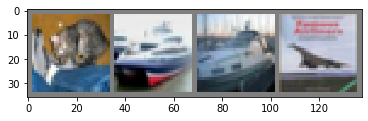

GroundTruth:    cat  ship  ship plane


In [198]:
########################################################################
# See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
# for more details on saving PyTorch models.
#
# 5. Test the network on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the network for 2 passes over the training dataset.
# But we need to check if the network has learnt anything at all.
#
# We will check this by predicting the class label that the neural network
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

########################################################################
# Next, let's load back in our saved model (note: saving and re-loading the model
# wasn't necessary here, we only did it to illustrate how to do so):

# net = Net()
# net.load_state_dict(torch.load(PATH))

# ########################################################################
# # Okay, now let us see what the neural network thinks these examples above are:

# outputs = net(images)

# ########################################################################
# # The outputs are energies for the 10 classes.
# # The higher the energy for a class, the more the network
# # thinks that the image is of the particular class.
# # So, let's get the index of the highest energy:
# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                               for j in range(4)))

In [10]:
########################################################################
# The results seem pretty good.
#
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

########################################################################
# That looks way better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 54 %
Accuracy of plane : 61 %
Accuracy of   car : 75 %
Accuracy of  bird : 38 %
Accuracy of   cat : 42 %
Accuracy of  deer : 43 %
Accuracy of   dog : 41 %
Accuracy of  frog : 68 %
Accuracy of horse : 60 %
Accuracy of  ship : 65 %
Accuracy of truck : 52 %
